In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

In [6]:
gold_price = pd.read_excel('./gold_prices_prediction.xlsx')
gold_price.head(2)

,Date,Price
0,2024-05-01,72050
1,2024-04-01,70415


In [7]:
gold_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    236 non-null    datetime64[ns]
 1   Price   236 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB


In [8]:
gold_price.describe()

,Date,Price
count,236,236.000000
mean,2014-07-17 00:24:24.406779648,28828.309322
min,2004-10-01 00:00:00,5966.000000
25%,2009-08-24 06:00:00,15653.250000
50%,2014-07-16 12:00:00,28451.000000
75%,2019-06-08 12:00:00,34283.750000
max,2024-05-01 00:00:00,72050.000000
std,NaN,15695.211732


Após algumas observações tiradas no **describe** e também no **info** percebemos algumas coisas referentes ao nosso **dataset**.

Ele possui apenas datas no formato *Datetime* e além disto, os preços tem uma variância muito grande entre si, trazendo um quesito muito mencionado na área de dados. Os **outliers e inliers** que são basicamente valores muito baixos/altos se comparados a média, contudo não podemos simplesmente desconsiderar estes valores por estarem fora da curva, pois eles fazem parte da evolução do valor do ouro na india. Mas, vamos lá! Vamos fazer um tratamento mais aprofundado para que consigamos trabalhar e fazer visualizaçõees/previsões supimpas ^-^

In [9]:
filtro_de_datas = gold_price.loc[(gold_price['Date'] >= '2004') & (gold_price['Date'] < '2025')]
filtro_de_datas.tail()

,Date,Price
231,2005-02-01,6245
232,2005-01-01,6000
233,2004-12-01,6307
234,2004-11-01,6528
235,2004-10-01,6329


In [10]:
filtro_de_datas.head()

,Date,Price
0,2024-05-01,72050
1,2024-04-01,70415
2,2024-03-01,67677
3,2024-02-01,62567
4,2024-01-01,62958


Realizamos um filtro bem bobinho só para colocar em prática mesmo o conhecimento que aprendemos referentes a filtros de análise, e após isto podemos perceber que todo dia 01 de cada mês dos anos presentes deste DATAFRAME foram extraídas informações sobre o valor do ouro na índia, logo, caso necessário a extração do dia, mês ou ano da coluna `Date`, poderemos filtrar os valores de mês e ano sem sermos prejudicados por conta desta escolha.

Este não é o primeiro notebook que faço com este dataframe, e sim o segundo. ----- Para o primeiro foi utilizado o modelo de aprendizado de regressão linear simples onde eu percebi que não houve uma mostra de valores boas o suficiente se comparadas com os dados mais atualizados referentes ao valor do ouro na India. Pude também visualizar uma certa discrepância ao pesquisar pelos valores antigos do ouro referentes as datas que são mostradas no DATAFRAME, contudo irei ignorar este fator pois não sei de onde exatamente os dados foram extraídos para comprovar esta hipotese.

Logo neste notebook eu peço para que considerem todos os valores aqui gerados como hipotéticos, pois não há informações mais detalhadas referentes a inflação, valorização e desvalorização da moeda que possam agregar para uma análise mais fidedigna e precisa do valor do ouro. Pois, a tendência do mesmo ao longo dos anos é o aumento do seu valor, simplesmente pelo fato deste não ter uma fonte infinita e sim finita.

In [11]:
initial_date =  gold_price['Date'].min()
final_date = gold_price['Date'].max()

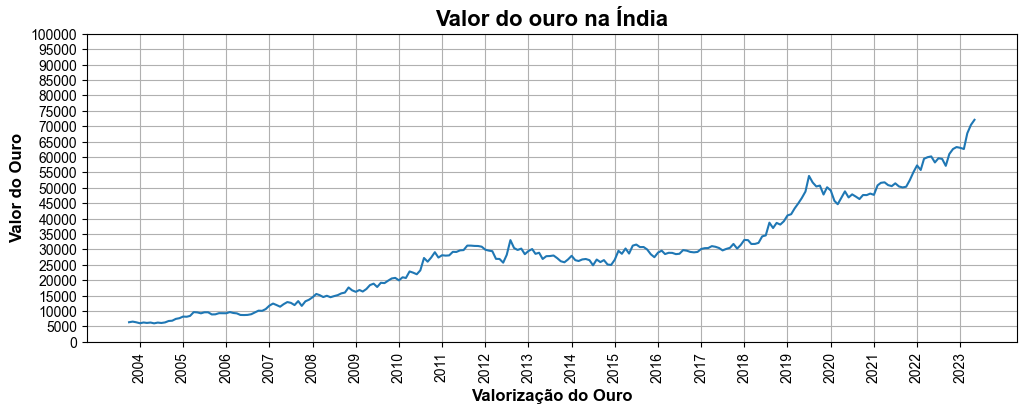

In [12]:
primeira_vista = gold_price

plt.figure(figsize=(12, 4))
plt.grid(visible= True)
plt.ylim(0, 100000)


sns.lineplot(data = primeira_vista, x = 'Date', y = 'Price')

plt.yticks(range(0, 105000, 5000))
plt.xticks(pd.date_range(start = initial_date, end = final_date, freq = 'YE'), rotation = 90)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y')) # Função para mostrar apenas o ano do formato Datetime.

sns.set_style('darkgrid')

plt.title('Valor do ouro na Índia', fontweight = 'bold', fontsize = 16)
plt.xlabel('Valorização do Ouro', fontweight = 'bold', fontsize = 12)
plt.ylabel('Valor do Ouro', fontweight = 'bold', fontsize = 12)
plt.show()


Com o gráfico acima gerado podemos ver a distribuição da valorização do ouro na moeda indiana (rúpia), onde os dados utilizados caminharam mais de 15 anos desde 2004, contudo como não temos informações referentes a valorização e desvalorização da moeda indiana e do dólar, não conseguiremos medir com maior precisão como será o valor do ouro na india nos próximos anos com exatidão.

Podendo apenas gerar pequenos insights para tentar entender um pouco mais sobre o crescimento do ouro, e também fatores que possam contribuir para um possível aumento contínuo ou queda repentina do valor se comparado aos últimos anos.

O modelo escolhido para ser utilizado foi o ARIMA (AutoRegressive Integrated Moving Average), o ARIMA permitirá trabalhar com essa série temporal de maneira mais completa, e também por ser um modelo normalmente utilizado para este tipo de trabalho, preferi dar continuidade para tornar minha base cada vez mais sólida com este modelo de séries temporais! Mas devo lembrar que existem também outras variações deste modelo, como o SARIMA que auxilia em dados que podem haver sazonalidade.

Então para a primeira etapa, é necessário compreender nossos dados para transformar estes em séries estacionarias, então utilizaremos do método adfuller para ver se nossa série pode ser considerada estacionaria ou não-estacionaria. Esse método é conhecido como Teste de Dickey-Fuller aumentado, ou Augmented Dickey-Fuller.  

In [13]:
primeira_vista_diferenca = primeira_vista['Price'].sort_values(ascending = True)

diferenciacao_dados = primeira_vista_diferenca.diff().dropna().reset_index(drop = True) #Esta linha tem a serventia de negativar os números, resetar o index e ordenar do menor para o maior.
result = adfuller(diferenciacao_dados)
print(f'ADF Statistical: {result[0]}.')
print(f'Valor de P: {result[1]}')
print(f'Valores Críticos: {result[4]}')

valor_primeira_diferenciacao = diferenciacao_dados.iloc[-1] #Guardando valor, para que eu possa reverter a diferenciação ao final do forecast.
diferenciacao_dados.tail()

ADF Statistical: -1.2882784174263264.
Valor de P: 0.6345177446977239
Valores Críticos: {'1%': -3.459105583381277, '5%': -2.8741898504150574, '10%': -2.5735117958412097}


230     391.0
231     245.0
232    4474.0
233    2738.0
234    1635.0
Name: Price, dtype: float64

In [14]:
diferenciacao_dados2 = diferenciacao_dados.diff().dropna()
result2 = adfuller(diferenciacao_dados2)

print(f'ADF Statistical: {result2[0]}.')
print(f'Valor de P: {result2[1]}')
print(f'Valores Críticos: {result2[4]}')

print(diferenciacao_dados2.tail())


ADF Statistical: -12.452803872865589.
Valor de P: 3.5444580670952324e-23
Valores Críticos: {'1%': -3.459105583381277, '5%': -2.8741898504150574, '10%': -2.5735117958412097}
230     383.0
231    -146.0
232    4229.0
233   -1736.0
234   -1103.0
Name: Price, dtype: float64


Quero optar por um maior rigor estatístico pois assim teremos uma maior fidelidade do resultado dos dados, por isto o processo de diferenciação foi realizado acima. Com isto tanto o valor da estatistica ADF se tornou menor que todos os valores estatísticos incluindo o que queremos trabalhar (1% de significância), enquanto o valor de P mostrou-se menor que as porcentagens escolhidas.

Quando falamos da comparação do Valor P com o valor crítico obtido, falamos de 1% == 0,01 // 5% == 0,05 // 10% == 0,10 e nesse caso temos uma notação cientifica negativa que tornou o valor de P mais próximo de 0, tornando-o menor que a significância que procuramos, logo podemos negar a hipotese nula.

`Ressaltando que, quando realizamos a diferenciação estamos adicionando +1 ao termo (D) do nosso modelo ARIMA, e quando não aplicamos a DIFF, ele é 0`

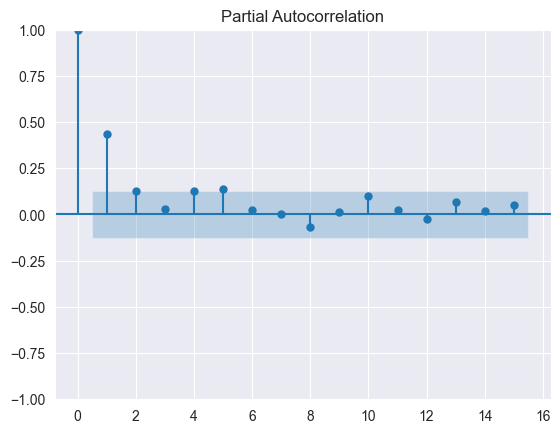

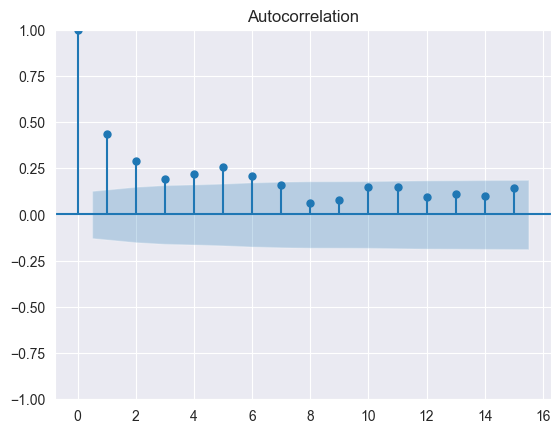

In [15]:
gold_PACF = plot_pacf(x = diferenciacao_dados, lags = 15)
gold_ACF = plot_acf(x = diferenciacao_dados, lags = 15)

Com as funções `PLOT_ACF`e `PLOT_PACF` poderemos identificar quantos termos P e Q teremos de utilizar para ter uma análise mais fidedigna, e também determinar como utilizaremos nosso modelo. Pois o modelo ARIMA em si possui 5 formas de ser utilizado. (AR, MA, ARMA, ARIMA, SARIMA), contudo não vou me aprofundar muito sobre o assunto aqui e irei dispor de outros modos do mesmo, em outros datasets para treinamento. Agora como identificar os termos do nosso modelo?

**PACF - Partial Auto-correlation Function**

- AR(p) = FAC(declinante) - - - FACP(trunca em P)
- MA(q) = FAC(trunca em Q) - - - FACP(declinante)
- ARMA(p, q) = FAC(declinante) - - - FACP(declinante)

Bom, podemos perceber que no gráfico de autocorrelação o mesmo é declinante e trunca em 2 na FACP, logo temos um modelo AR(2)


In [16]:
lista_do_modelo = diferenciacao_dados
lista_do_modelo = lista_do_modelo.to_list()
modelo = ARIMA(lista_do_modelo, order = (1,2, 1))
lista_do_modelo = modelo.fit()
print(lista_do_modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  235
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1769.220
Date:                Mon, 22 Jul 2024   AIC                           3544.439
Time:                        16:45:23   BIC                           3554.792
Sample:                             0   HQIC                          3548.614
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4117      0.051     -8.030      0.000      -0.512      -0.311
ma.L1         -0.9998      1.379     -0.725      0.468      -3.702       1.702
sigma2      2.253e+05   3.05e+05      0.738      0.4

Após treinar o nosso modelo iremos preparar um novo DataFrame para que o mesmo possa dispor da nova coleção de dados atualizados referentes ao valor do ouro ao longo dos anos. Como previsões de longo prazo sempre possuem uma taxa de erro elevada, irei optar por realizar previsões de curto prazo.

Na construção deste código passei por algumas dificuldades referentes ao modelo, contudo foi muito proveitoso toda a caminhada que realizei para chegar até aqui. Este modelo é muito bom de se trabalhar e ele possui uma capacidade de predição incrível da qual eu achei magnifica se comparada a utilização de uma regressão linear simples que eu tentei antes de passar pro ARIMA. Tirando como forma de curiosidade, após todo o treinamento e separação dos parâmetros para utilização do modelo precitado tive resultados um tanto insatisfatórios que começavam no mês seguinte após o termino das inserções de dados, o valor previsto foi de 55.000 rupias indianas. Sendo que a tendência do ouro no mundo atual é de se tornar mais caro a cada dia, por ser um material limitado e raro de ser encontrado. E posso afirmar que utilizar ARIMA foi a melhor decisão pois o modelo conseguiu compreender que a tendência do valor seria uma crescente exponencial ao longo dos meses.

In [17]:
predicting_gold = lista_do_modelo.forecast(steps = 7).round(3)
predicting_gold

array([2100.663, 1920.527, 2006.259, 1982.536, 2003.874, 2006.661,
       2017.085])

In [18]:
data_inicial = np.datetime64('2024-06-01')
data_final = np.datetime64('2025-01-01')
agrupar_datas = np.arange(data_inicial, data_final, dtype= 'datetime64[M]')

gold_prediction = pd.DataFrame(agrupar_datas, columns = ['Date'])


Após a previsão dos valores e da criação de um novo DataFrame, realizamos a alteração dos valores obtidos a partir da nossa previsão para retornar as diferenciações e então obter um valor mais próximo do que tivemos acesso no DataFrame original. E então após realizar todas as operações necessárias apenas realizamos uma concatenação entre as tabelas para inserir novas informações.

In [19]:
diferenca1 = predicting_gold.cumsum() + valor_primeira_diferenciacao #Com isto voltamos uma diferenciação, faltando mais uma para estar em conformidade com o nosso dado.

ultimo_valor_original = primeira_vista['Price'].sort_values(ascending = True).reset_index(drop = True)
ultimo_valor_original = ultimo_valor_original.iloc[-1] #Este processo é feito para retornar a diferenciação mais uma vez, fazendo com que o dado não tenha mais diferenciações por assim dizer.

diferenca0 = diferenca1.cumsum() + ultimo_valor_original
diferenca0

array([ 75785.663,  81441.853,  89104.302,  98749.287, 110398.146,
       124053.666, 139726.271])

In [23]:
gold_prediction['Price'] = diferenca0
gold_prediction

dados_finais = pd.concat([gold_price, gold_prediction], ignore_index = True)
dados_finais.sort_values(by= 'Date', ascending = False)
dados_finais

,Date,Price
0,2024-05-01,72050.000
1,2024-04-01,70415.000
2,2024-03-01,67677.000
3,2024-02-01,62567.000
4,2024-01-01,62958.000
...,...,...
238,2024-08-01,89104.302
239,2024-09-01,98749.287
240,2024-10-01,110398.146
241,2024-11-01,124053.666


In [50]:
dados_finais['Ano'] = dados_finais['Date'].dt.year
dados_finais.head(2)

,Date,Price,Ano
0,2024-05-01,72050.0,2024
1,2024-04-01,70415.0,2024


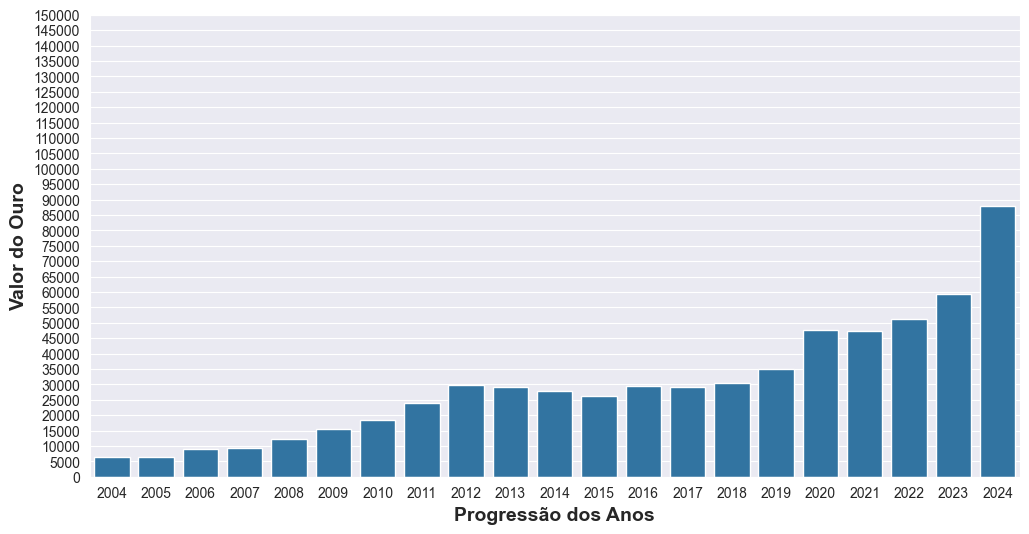

In [51]:
plt.figure(figsize=(12,6))

sns.barplot(data = dados_finais, x = 'Ano', y = 'Price', errorbar=('ci', 0))

plt.xlabel('Progressão dos Anos', fontweight = 'bold', fontsize = 14)

plt.yticks(range(0, 155000, 5000))
plt.ylabel('Valor do Ouro', fontweight = 'bold', fontsize = 14)
plt.show()